# Plot footprints and CREsted model attribution scores

In [1]:
import os
import anndata
import pandas as pd
import crested

import scprinter as scp

2025-08-20 14:18:49.448 | WARNING  | crested.tl:<module>:25 - modiscolite is not installed, 'crested.tl.modisco' module will not be available.
/lustre1/project/stg_00002/mambaforge/vsc35862/envs/scprinter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [25]:
zip_folder = "../../../../../../data/hydrop/mcortex/paper_zips"
printer_hydrop_object_path = f"{zip_folder}/10x_hydropv2_comparisons_data/printer/printer_mouse_hydropv2.h5ad"
printer_10x_object_path = f"{zip_folder}/10x_hydropv2_comparisons_data/printer/printer_mouse_10x.h5ad"
barcodegroups_10x_path = f"{zip_folder}/10x_hydropv2_comparisons_data/printer/barcodegroups_mouse_10x.csv"
barcodegroups_hydrop_path = f"{zip_folder}/10x_hydropv2_comparisons_data/printer/barcodegroups_mouse_hydropv2.csv"
model_folder_path = f"{zip_folder}/10x_hydropv2_comparisons_models/finetuned/hydrop_allcells_allreads/"
fa_file_path = "../../../../../../../../../res_00001/genomes/10xgenomics/CellRangerARC/refdata-cellranger-arc-mm10-2020-A-2.0.0/fasta/genome.fa"

In [3]:
genome = scp.genome.mm10

In [4]:
printer_hydrop = scp.load_printer(printer_hydrop_object_path, genome)
printer_10x = scp.load_printer(printer_10x_object_path, genome)

In [7]:
barcodegroups_hydrop = pd.read_csv(barcodegroups_hydrop_path, header=0, sep="\t")
barcodegroups_10x = pd.read_csv(barcodegroups_10x_path, header=0, sep="\t")

In [8]:
barcodegroups_hydrop.head(10)

,obs_name,cell_type
0,AACAACCATCCCACGCTATTCTTCACCTTCpart2,Micro_PVM
1,AAGCAGATAGAAGGTGTGGTATCGACCTTGpart2,OPC
2,AAGCAGATAGAAGGTGTGGTGAACACTGGApart2,Pvalb
3,AAGCAGATAGGCTCATCACTGTCTATTCCApart2,L6_CT
4,AAGCAGATAGGGCTCAATACGGTGGATTCApart2,Astro
5,AAGCAGATAGGTAATTGAGGAAGCCGCATApart2,Astro
6,AAGCAGATAGTATCACACGAGAGAGAAGTCpart2,Oligo
7,AAGCAGATAGTCGCCTAAGTGAGGTTAATGpart2,L2_3_IT
8,AAGCAGATAGTTAACAGTCATGGCTTAACApart2,Micro_PVM
9,AAGCAGATAGTTCTTCTGATACCTGAGATGpart2,Astro


In [9]:
barcodegroups_10x["cell_type"] = barcodegroups_10x.cell_type.astype(str)
barcodegroups_10x["obs_name"] = barcodegroups_10x.obs_name.astype(str)

barcodegroups_hydrop["cell_type"] = barcodegroups_hydrop.cell_type.astype(str)
barcodegroups_hydrop["obs_name"] = barcodegroups_hydrop.obs_name.astype(str)

In [10]:
cell_grouping_hydrop, group_names_hydrop = scp.utils.df2cell_grouping(printer_hydrop, barcodegroups_hydrop)
cell_grouping_10x, group_names_10x = scp.utils.df2cell_grouping(printer_10x, barcodegroups_10x)

In [11]:
def convert_region_to_width(region, width: int = 2114):
    start, end = region.split(":")[1].split("-")
    start = int(start)
    end = int(end)
    center = (start + end) // 2
    start = center - width // 2
    end = center + width // 2
    return f"{region.split(':')[0]}:{start}-{end}"

In [12]:
# biccn enhancer regions with their annotations
regions_of_interest_unchanged = ["chr2:38111566-38112137", "chr3:110093884-110094329"]
regions_of_interest_500 = [convert_region_to_width(region, 500) for region in regions_of_interest_unchanged]
regions_of_interest_2114 = [convert_region_to_width(region, 2114) for region in regions_of_interest_unchanged] # model input
classes_of_interest = ["Astro", "L5_ET"]

## Get footprints scores

In [13]:
printer_hydrop.load_disp_model()
printer_hydrop.load_bindingscore_model("TF", scp.datasets.pretrained_TFBS_model)
printer_hydrop.load_bindingscore_model("Nuc",scp.datasets.pretrained_NucBS_model)

printer_10x.load_disp_model()
printer_10x.load_bindingscore_model("TF", scp.datasets.pretrained_TFBS_model)
printer_10x.load_bindingscore_model("Nuc",scp.datasets.pretrained_NucBS_model)

In [14]:
# hydrop footprint scores for all classes for regions of interest
import time
import numpy as np

start = time.time()
scp.tl.get_footprint_score(
    printer_hydrop,
    cell_grouping_hydrop,
    group_names_hydrop,
    regions_of_interest_500,
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    n_jobs=16,
    save_key="500_footprints",
    backed=False, # leads to corrupted files
    overwrite=True)
print ("takes", time.time()-start)

estimated file size: 0.01 GB
Creating 500_footprints in printer.footprintsadata
obs=groups, var=regions
1000 100
Loading insertion profiles


collecting multi-scale footprints: 100%|██████████| 198/198 [00:15<00:00, 12.55it/s]

takes 368.08080673217773


In [15]:
# 10x footprints
start = time.time()
scp.tl.get_footprint_score(
    printer_10x,
    cell_grouping_10x,
    group_names_10x,
    regions_of_interest_500,
    modes=np.arange(2, 101),
    footprintRadius=None,
    flankRadius=None,
    n_jobs=16,
    save_key="500_footprints",
    backed=False, # leads to corrupted files
    overwrite=True)
print ("takes", time.time()-start)

estimated file size: 0.01 GB
Creating 500_footprints in printer.footprintsadata
obs=groups, var=regions
1000 100
Loading insertion profiles


collecting multi-scale footprints: 100%|██████████| 198/198 [00:05<00:00, 35.77it/s]

takes 306.74141669273376


2025-08-20 16:19:23 - INFO - maxp pruned
2025-08-20 16:19:23 - INFO - cmap pruned
2025-08-20 16:19:23 - INFO - kern dropped
2025-08-20 16:19:23 - INFO - post pruned
2025-08-20 16:19:23 - INFO - FFTM dropped
2025-08-20 16:19:23 - INFO - GPOS pruned
2025-08-20 16:19:23 - INFO - GSUB pruned
2025-08-20 16:19:23 - INFO - glyf pruned
2025-08-20 16:19:23 - INFO - Added gid0 to subset
2025-08-20 16:19:23 - INFO - Added first four glyphs to subset
2025-08-20 16:19:23 - INFO - Closing glyph list over 'MATH': 28 glyphs before
2025-08-20 16:19:23 - INFO - Glyph names: ['.notdef', '.null', 'A', 'M', 'a', 'c', 'colon', 'e', 'eight', 'f', 'h', 'hyphen', 'i', 'l', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'three', 'two', 'u', 'zero']
2025-08-20 16:19:23 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 25, 27, 29, 36, 48, 68, 70, 72, 73, 75, 76, 79, 81, 82, 83, 85, 86, 87, 88]
2025-08-20 16:19:23 - INFO - Closed glyph list over 'MATH': 28 glyphs after
2025-08-20 16:

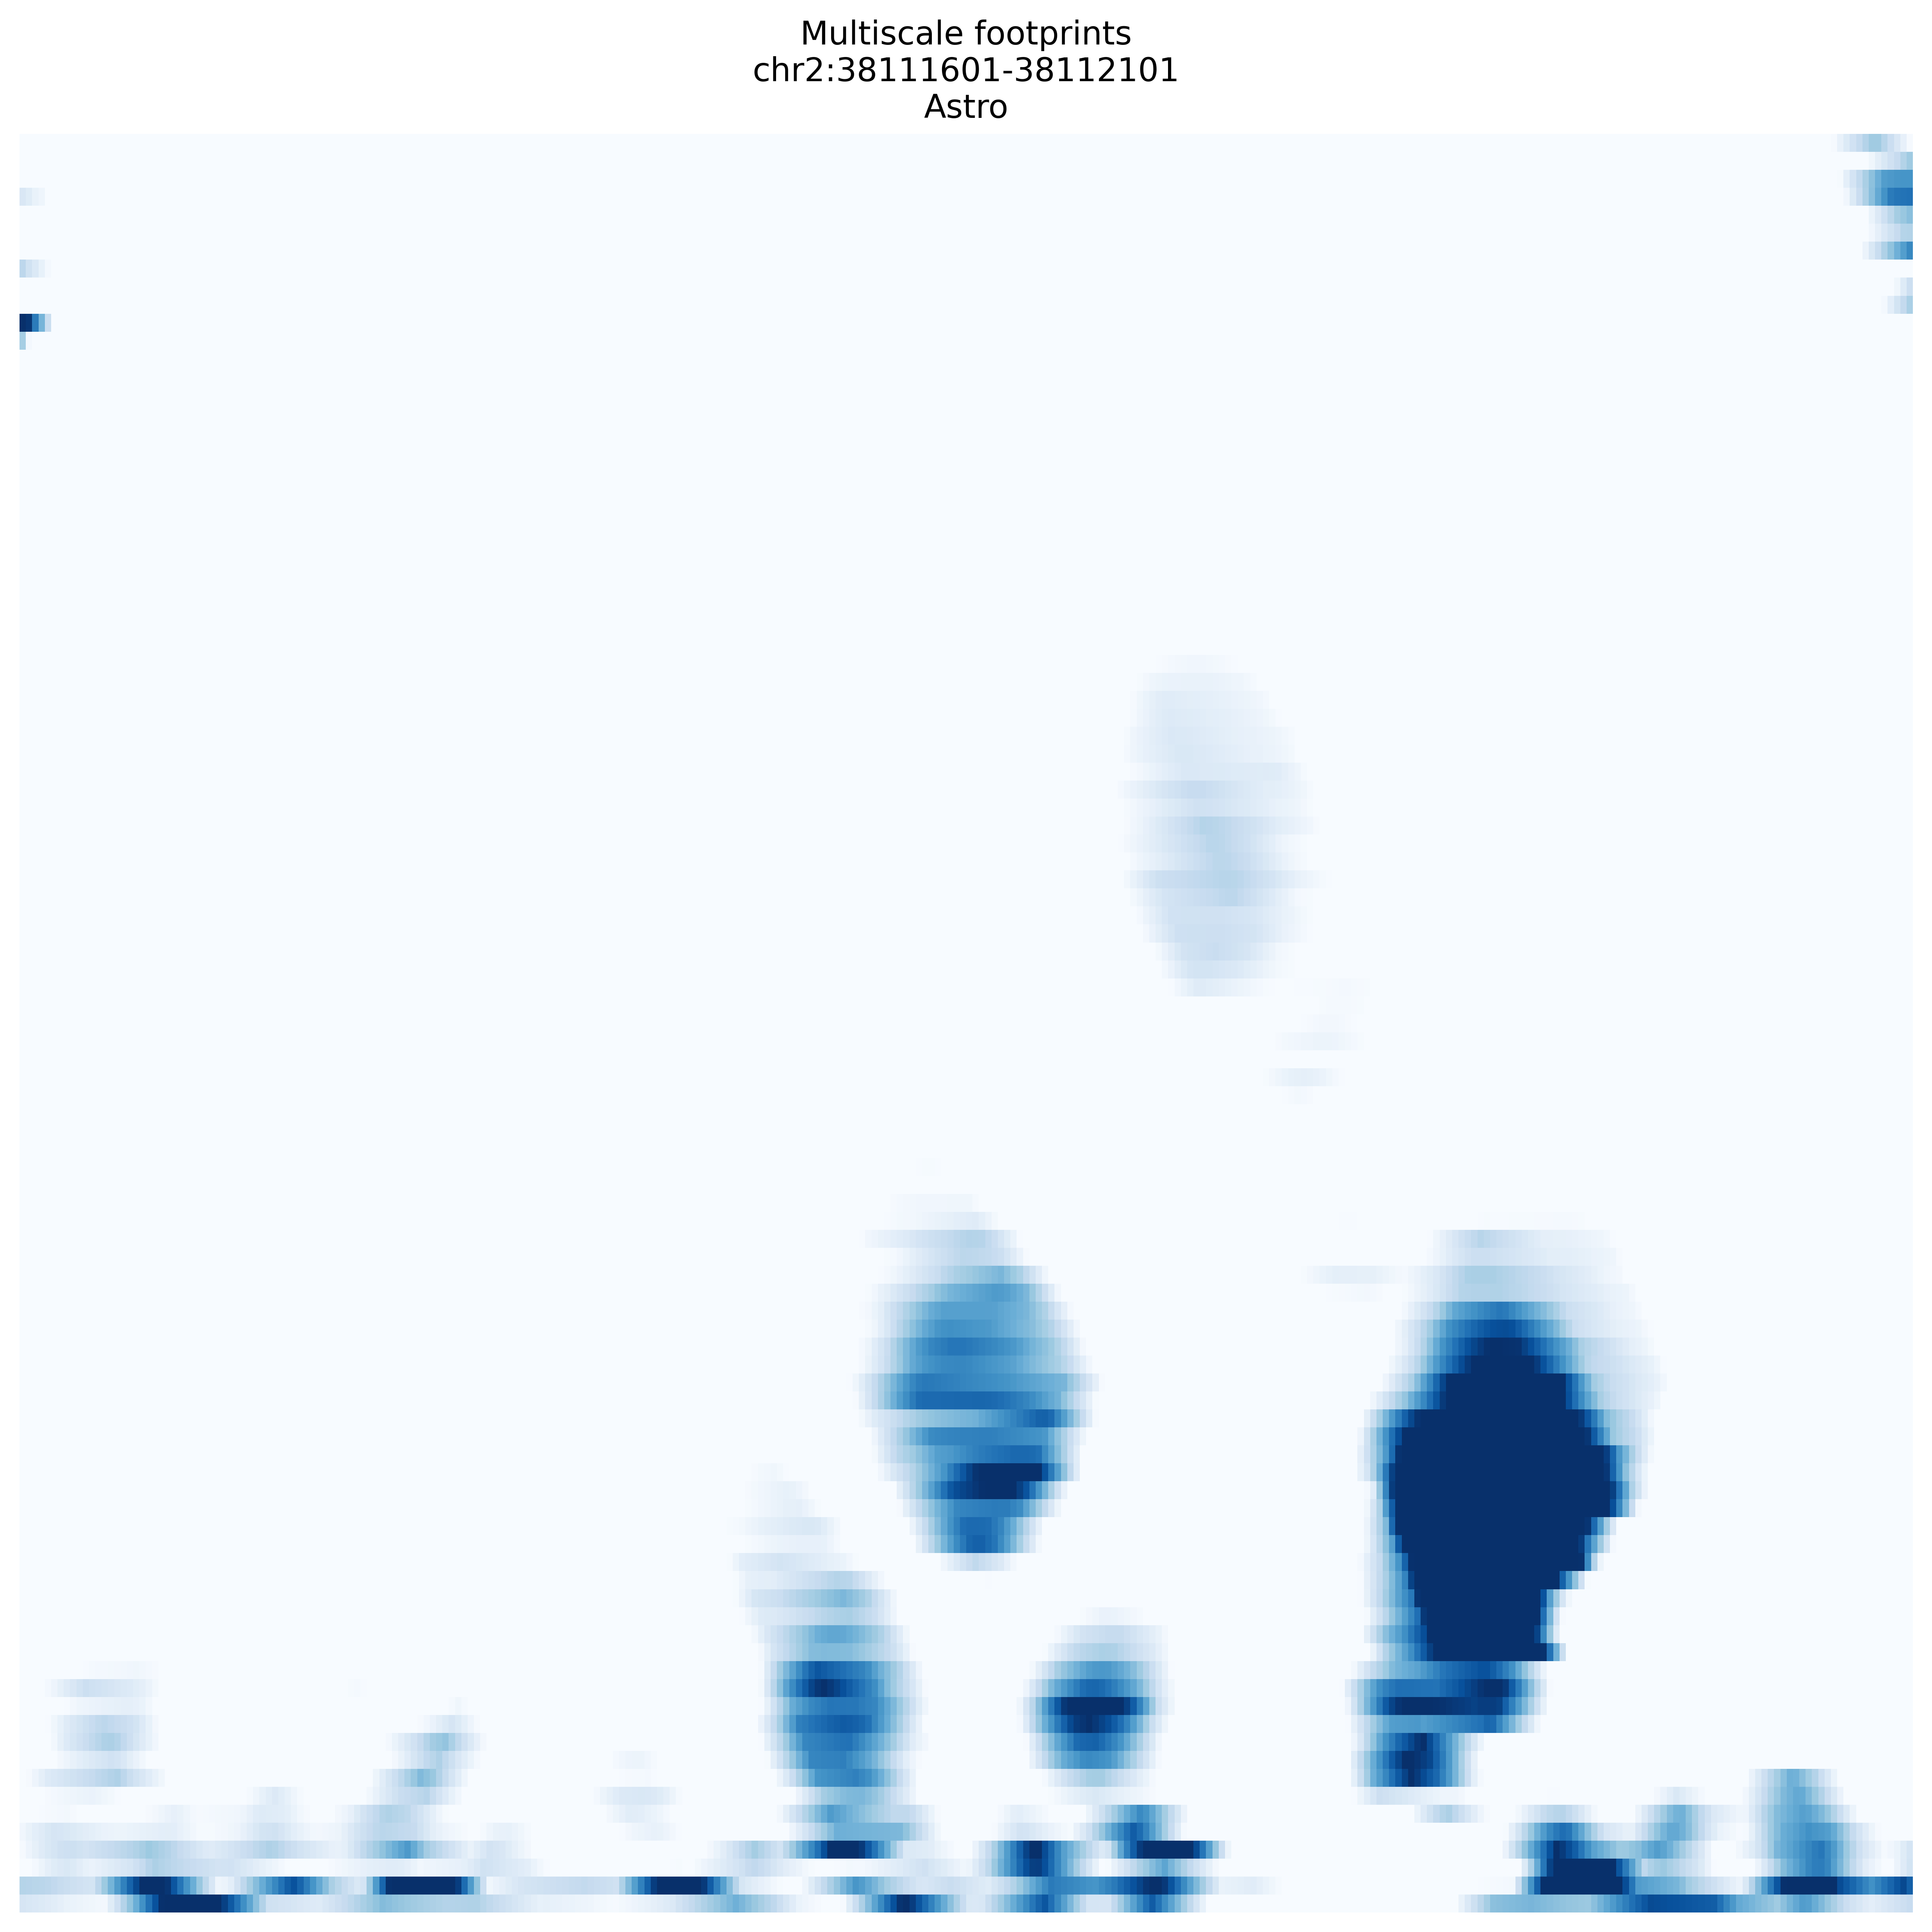

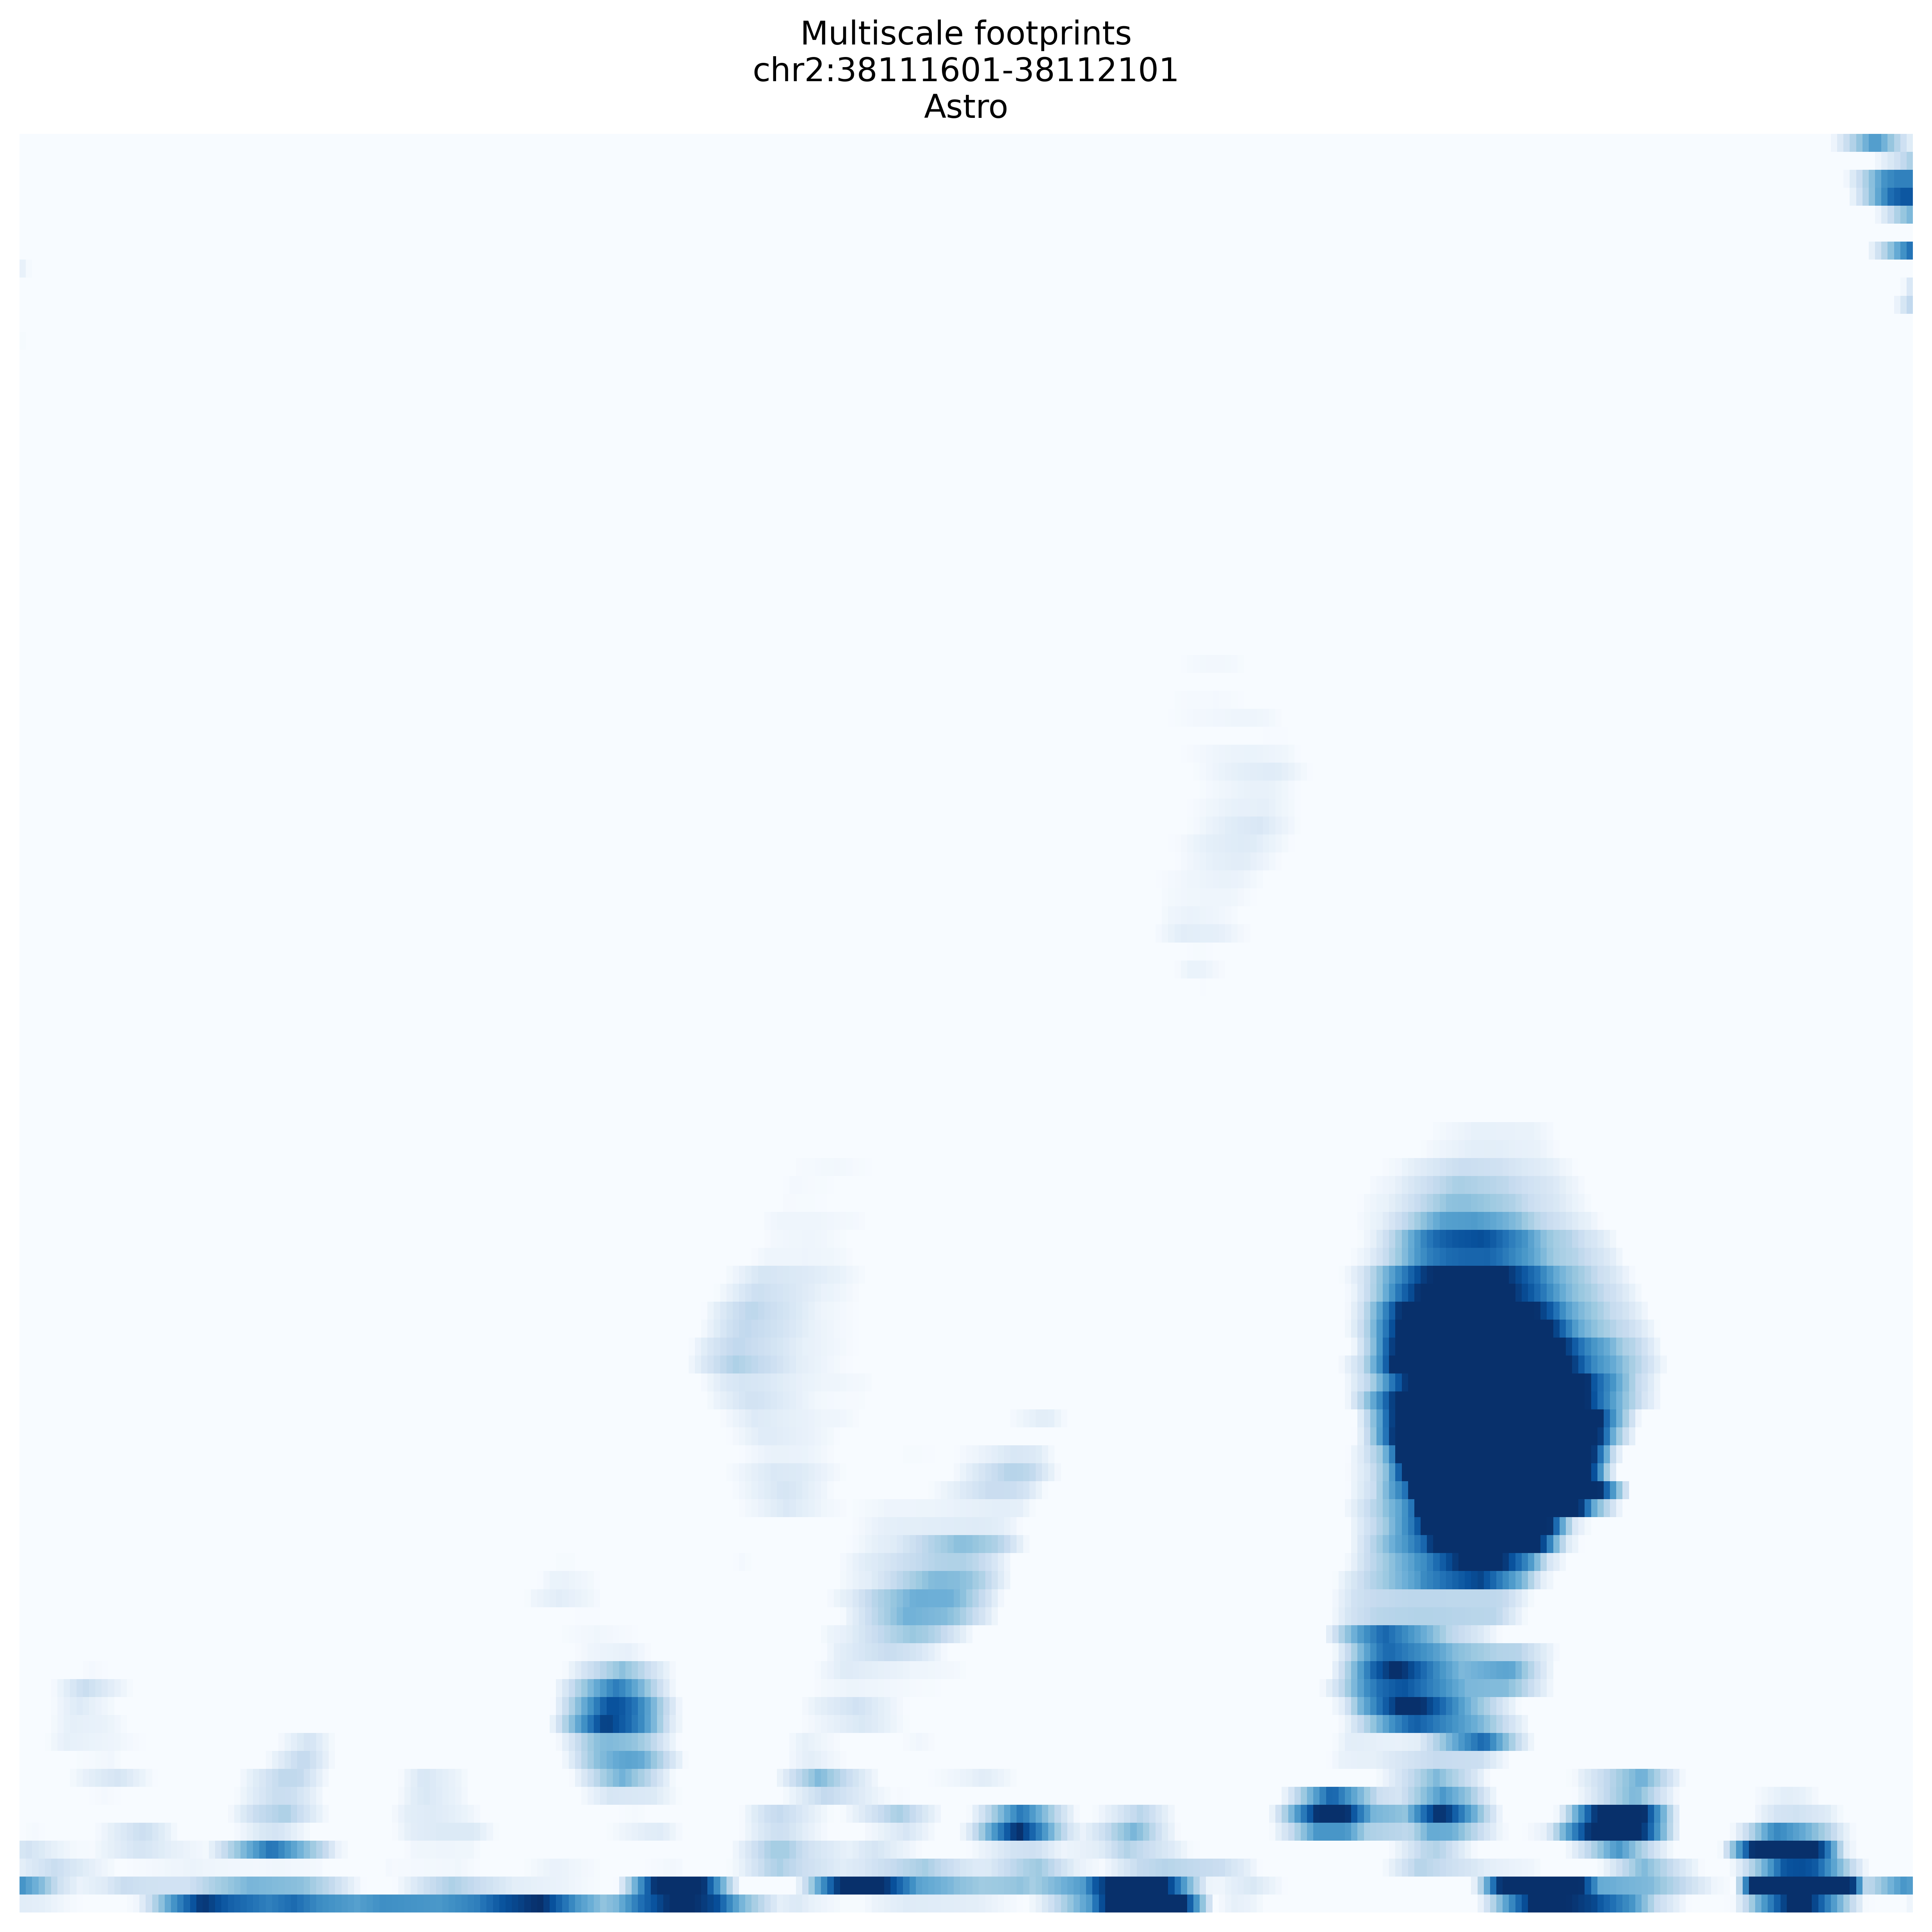

In [43]:
## test plots
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 500
fig = plt.figure(figsize=(10, 10))
axs = fig.subplots(1, 1)
scp.pl.plot_footprints(
    printer_hydrop,
    save_key="500_footprints",
    group_names="Astro",
    region=convert_region_to_width("chr2:38111566-38112137",500),
    scales=None,
    ax=axs,
    cmap="Blues",
    vmin=0.5,
    vmax=2.0,
    
)
plt.savefig("footprints_Astro_hydrop.pdf", bbox_inches="tight", transparent=True)

fig = plt.figure(figsize=(10, 10))
axs = fig.subplots(1, 1)
scp.pl.plot_footprints(
    printer_10x,
    save_key="500_footprints",
    group_names="Astro",
    region=convert_region_to_width("chr2:38111566-38112137", 500),
    scales=None,
    ax=axs,
    cmap="Blues",
    vmin=0.5,
    vmax=2.0,
)
plt.savefig("footprints_Astro_10x.pdf", bbox_inches="tight", transparent=True)

2025-08-20 16:16:25 - INFO - maxp pruned
2025-08-20 16:16:26 - INFO - cmap pruned
2025-08-20 16:16:26 - INFO - kern dropped
2025-08-20 16:16:26 - INFO - post pruned
2025-08-20 16:16:26 - INFO - FFTM dropped
2025-08-20 16:16:26 - INFO - GPOS pruned
2025-08-20 16:16:26 - INFO - GSUB pruned
2025-08-20 16:16:26 - INFO - glyf pruned
2025-08-20 16:16:26 - INFO - Added gid0 to subset
2025-08-20 16:16:26 - INFO - Added first four glyphs to subset
2025-08-20 16:16:26 - INFO - Closing glyph list over 'MATH': 33 glyphs before
2025-08-20 16:16:26 - INFO - Glyph names: ['.notdef', '.null', 'E', 'L', 'M', 'T', 'a', 'c', 'colon', 'e', 'eight', 'f', 'five', 'four', 'h', 'hyphen', 'i', 'l', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'six', 'space', 't', 'three', 'u', 'underscore', 'zero']
2025-08-20 16:16:26 - INFO - Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 22, 23, 24, 25, 27, 28, 29, 40, 47, 48, 55, 66, 68, 70, 72, 73, 75, 76, 79, 81, 82, 83, 85, 86, 87, 88]
2025-08-20 16:16:26 - INFO - 

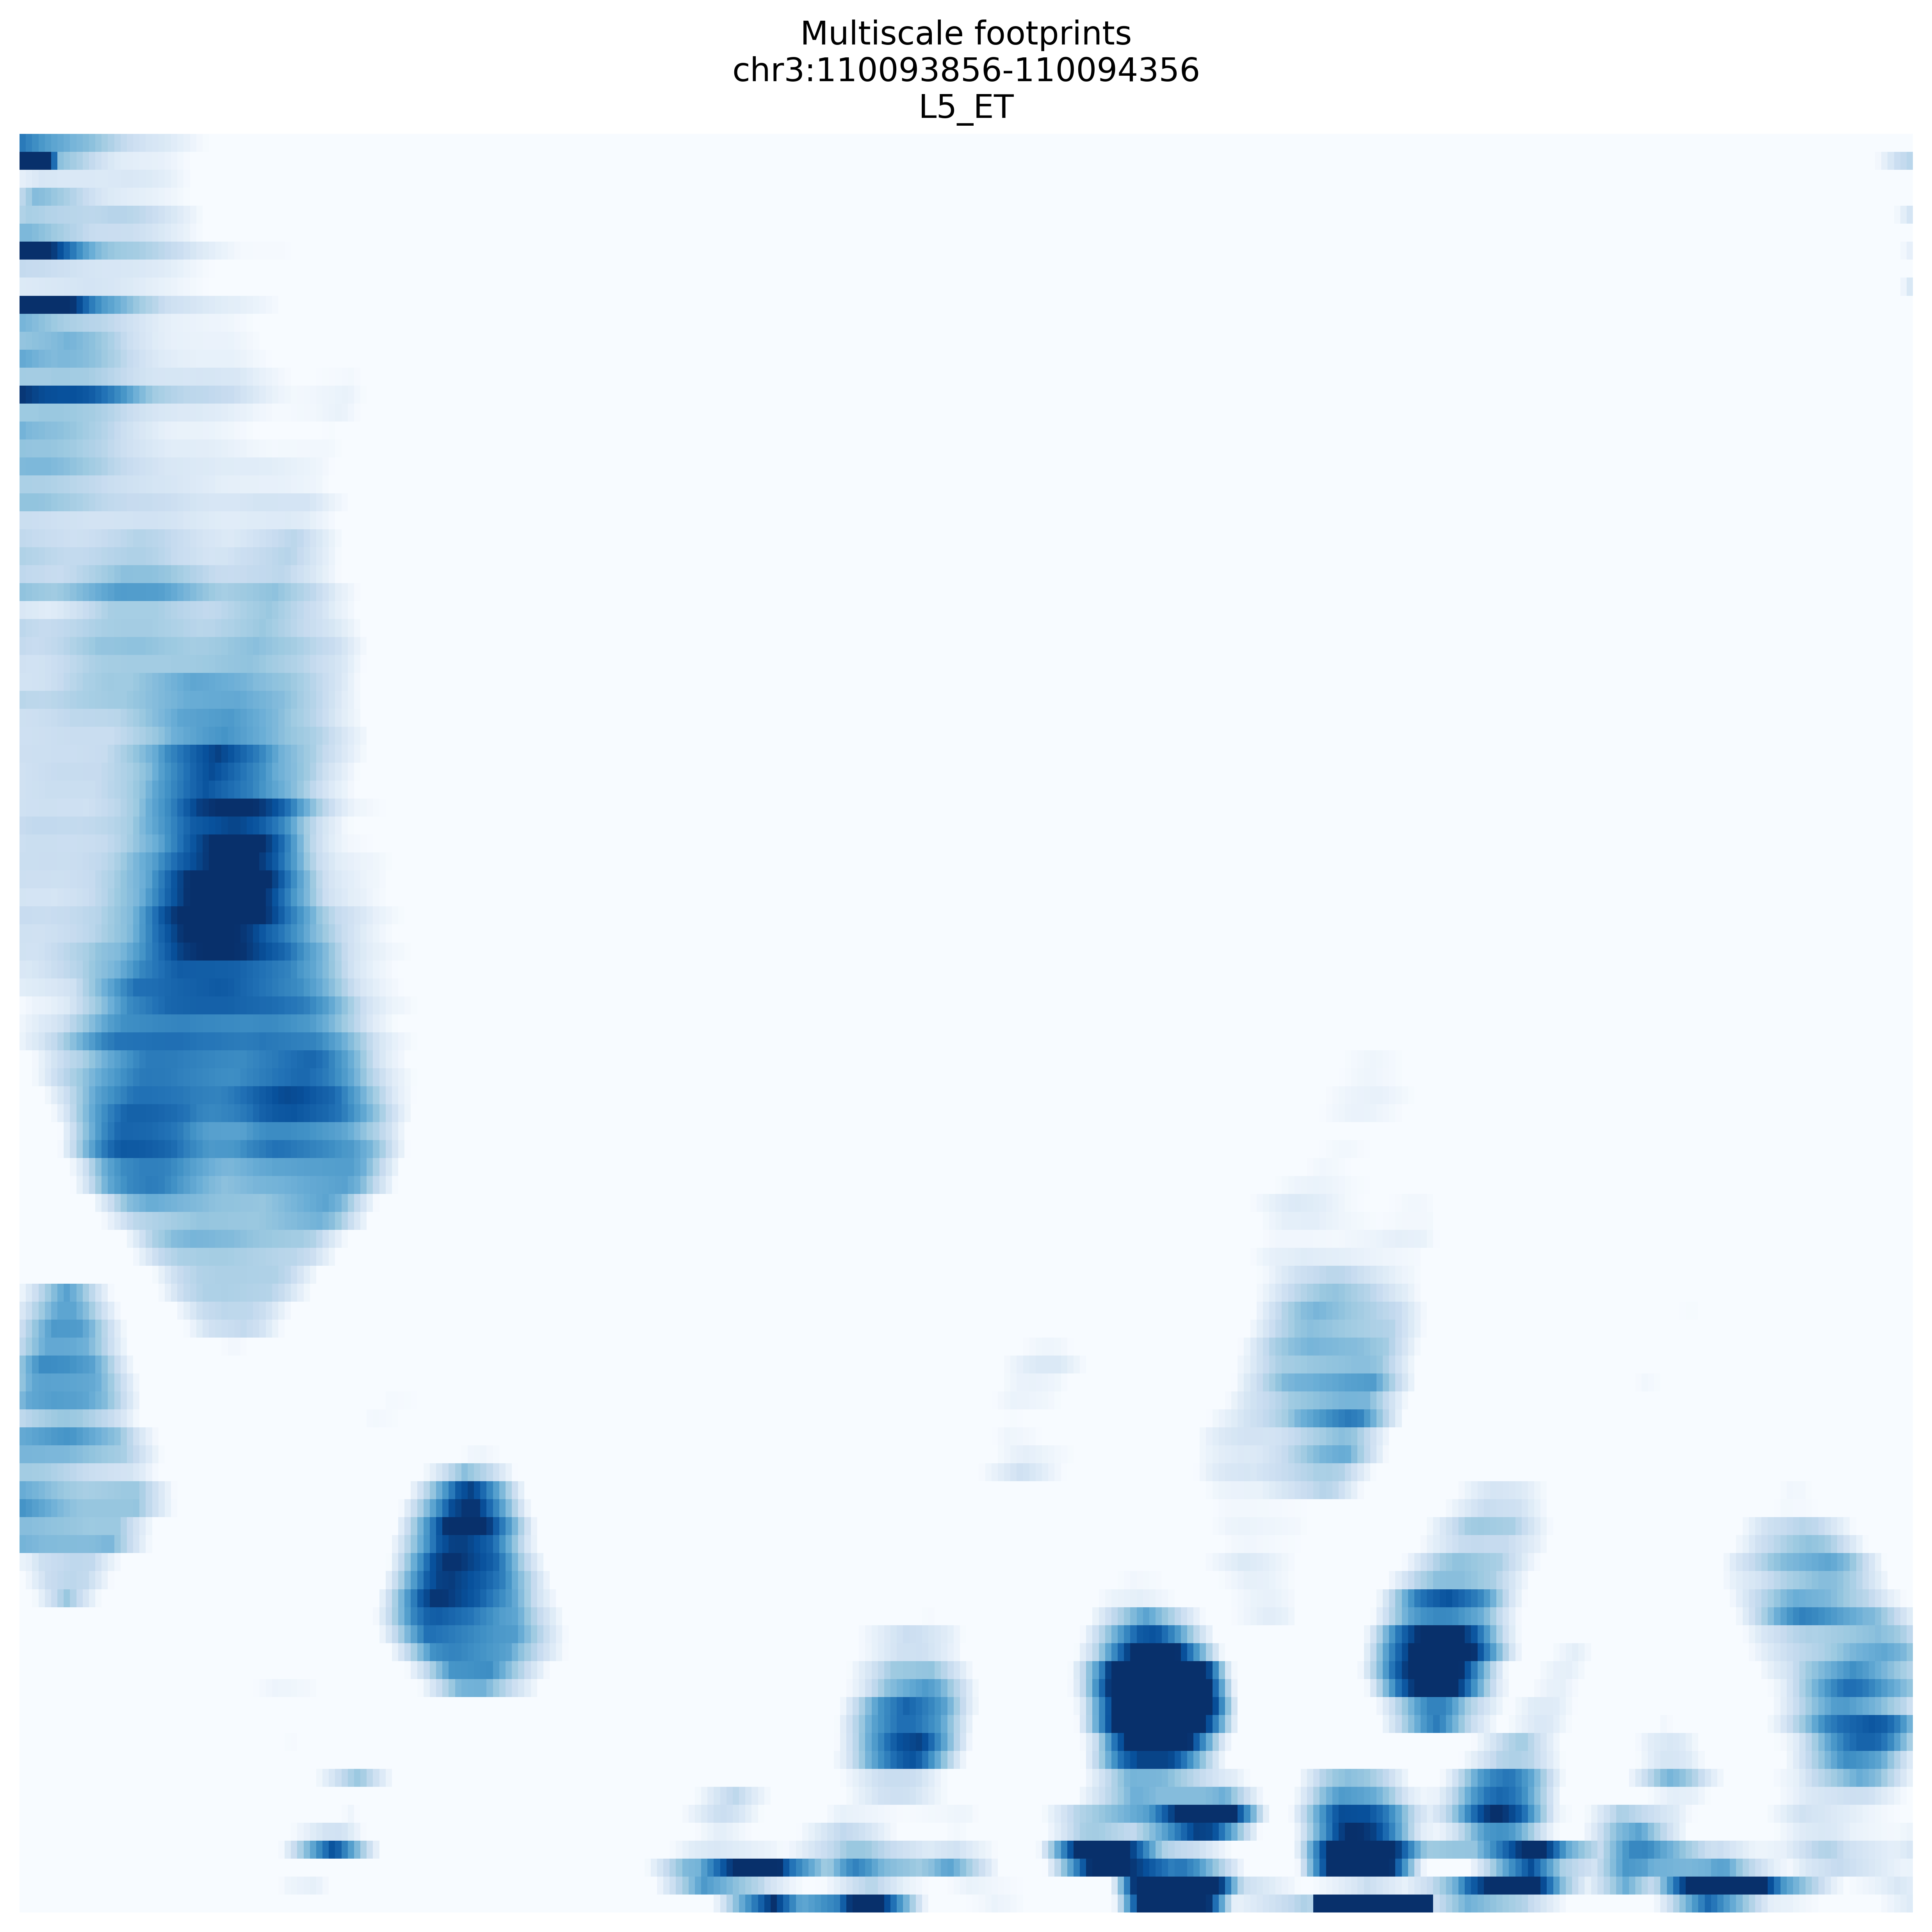

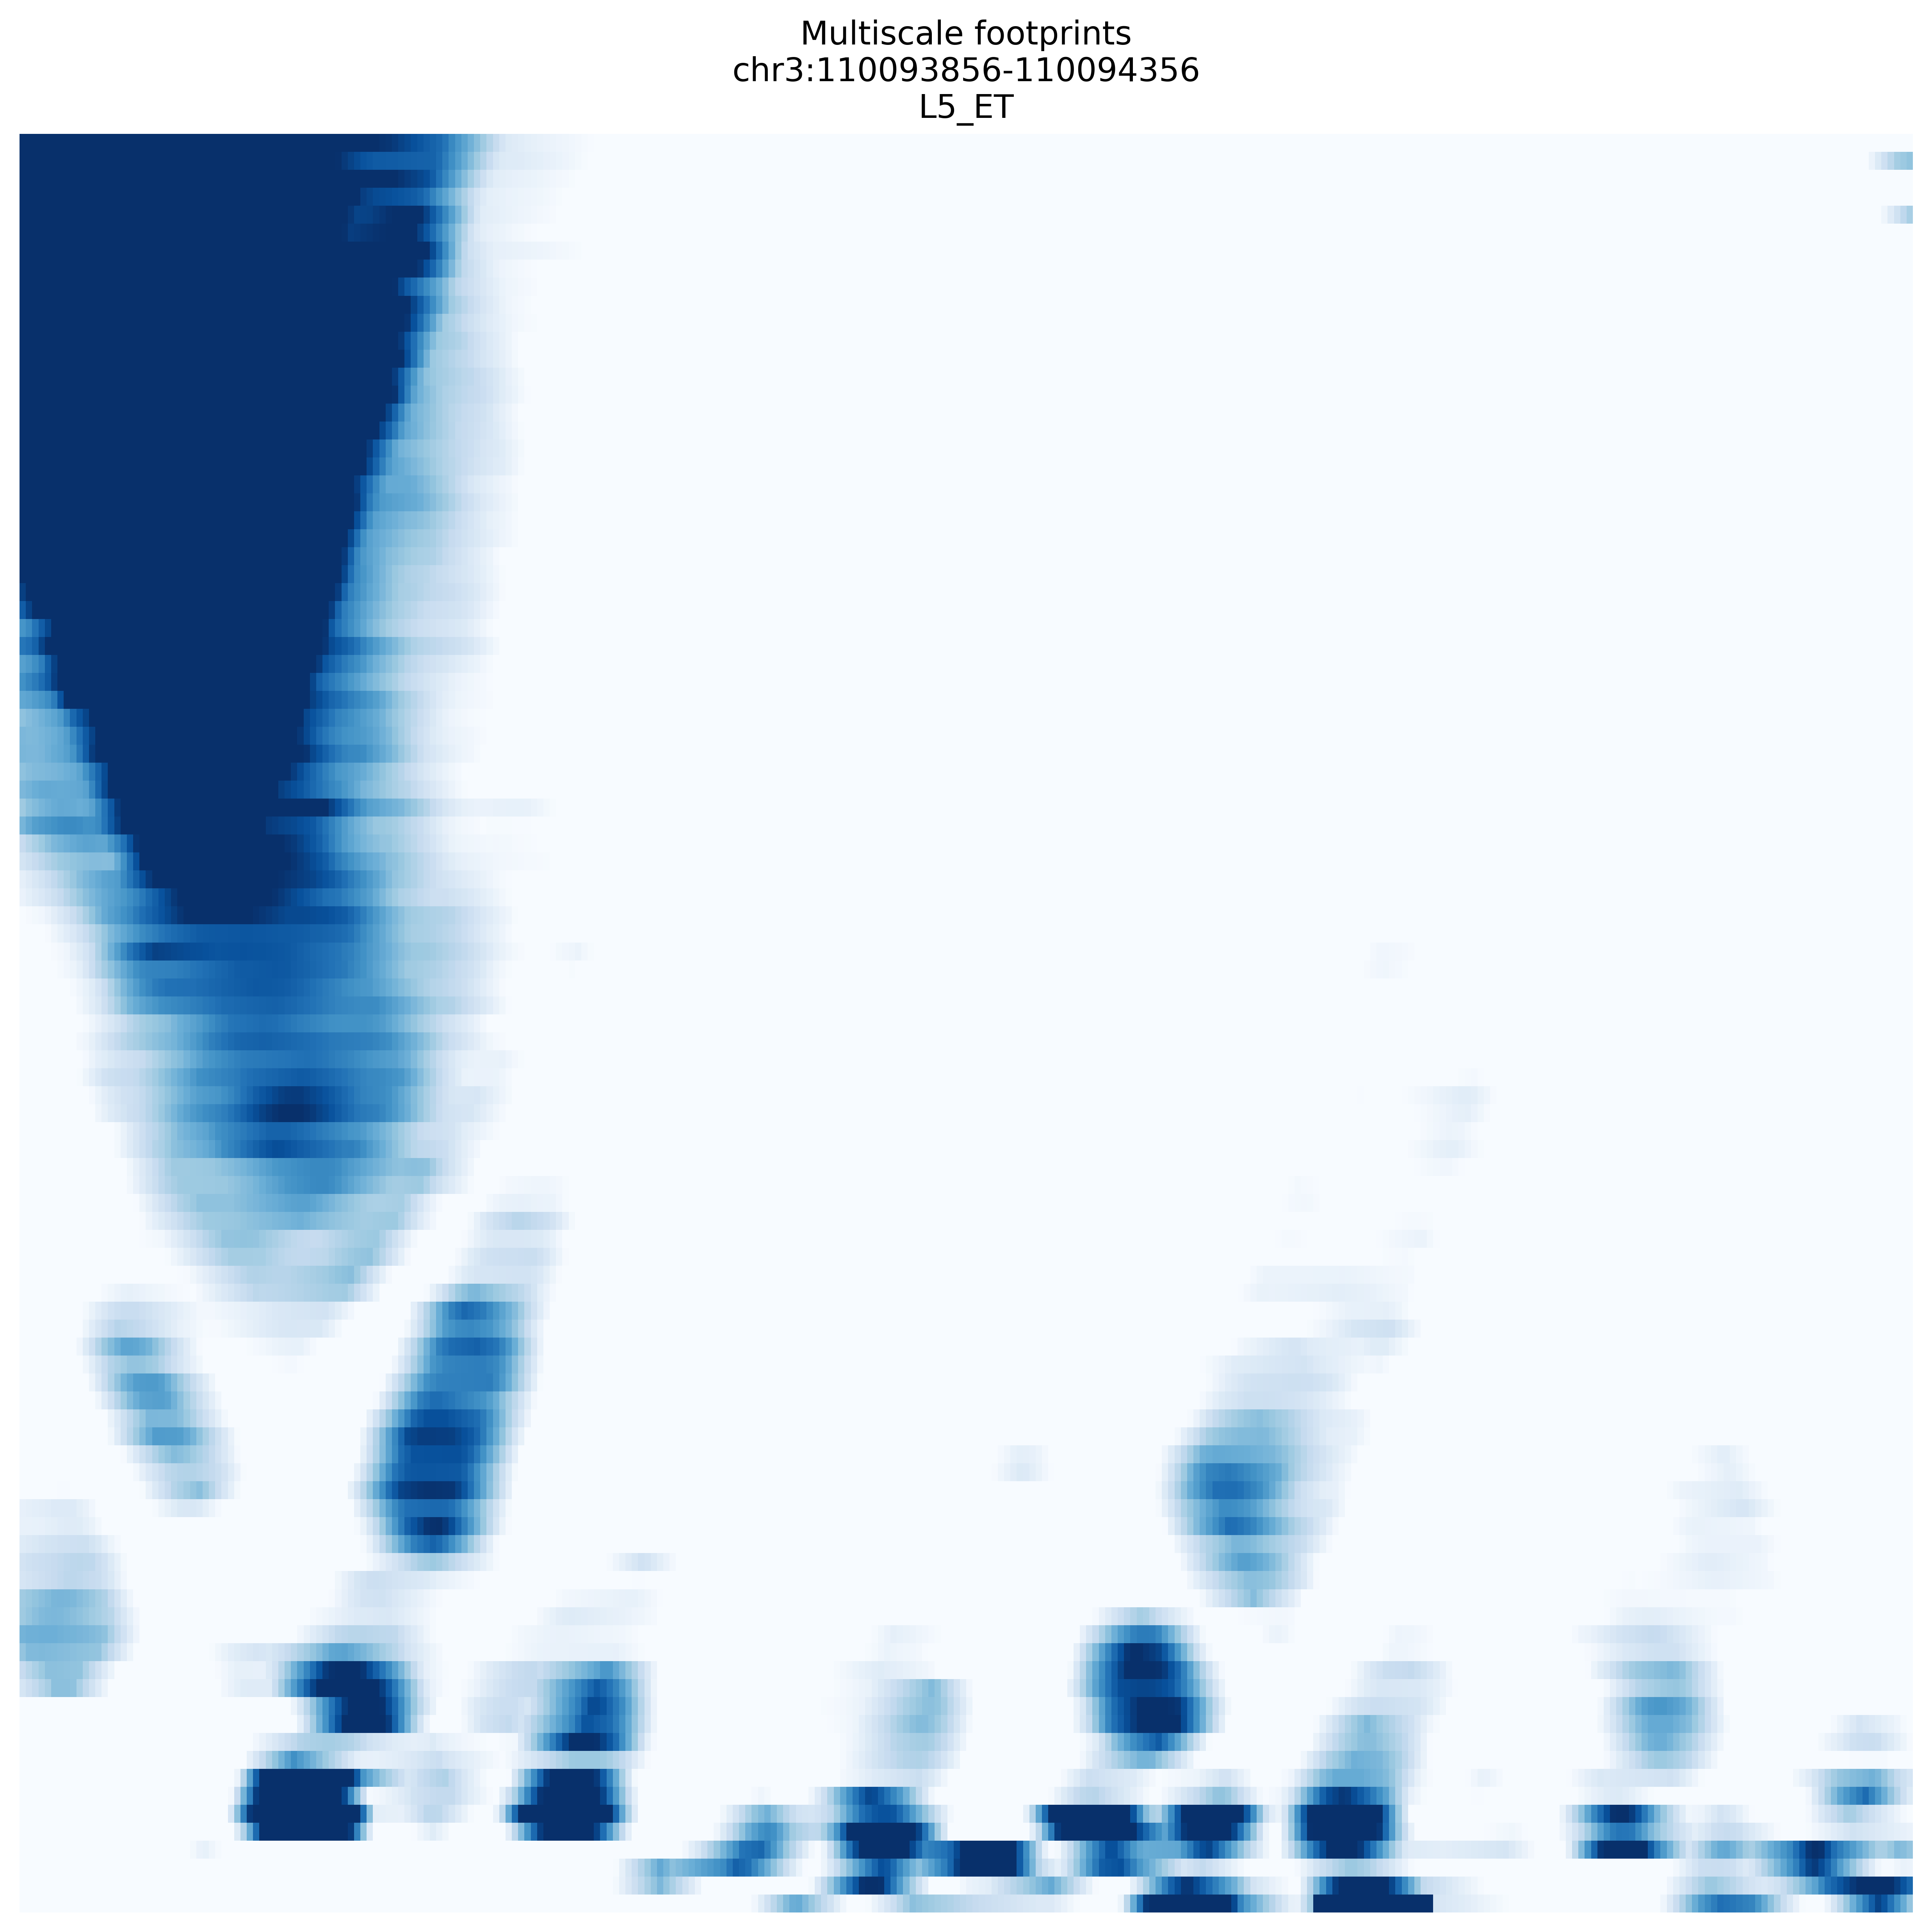

In [39]:
## test plots
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
axs = fig.subplots(1, 1)
scp.pl.plot_footprints(
    printer_hydrop,
    save_key="500_footprints",
    group_names="L5_ET",
    region=convert_region_to_width("chr3:110093884-110094329",500),
    scales=None,
    ax=axs,
    cmap="Blues",
    vmin=0.5,
    vmax=2.0,
)
plt.savefig("footprints_L5_ET_hydrop.pdf", bbox_inches="tight", transparent=True)

fig = plt.figure(figsize=(10, 10))
axs = fig.subplots(1, 1)
scp.pl.plot_footprints(
    printer_10x,
    save_key="500_footprints",
    group_names="L5_ET",
    region=convert_region_to_width("chr3:110093884-110094329", 500),
    scales=None,
    ax=axs,
    cmap="Blues",
    vmin=0.5,
    vmax=2.0,
)
plt.savefig("footprints_L5_ET_10x.pdf", bbox_inches="tight", transparent=True)

## Contrib scores (Hydrop)

Best ran on GPU

In [19]:
import h5py
import numpy as np

with h5py.File(printer_hydrop.genome.fetch_bias(), "r") as dct:
    precomputed_bias = {chrom: np.array(dct[chrom]) for chrom in dct.keys()}

In [22]:
import keras
import crested

models = []
# load models and permute inputs (compatible with tangermeme plotting funcs)
for model in os.listdir(model_folder_path):
    if model.endswith(".keras"):
        models.append(
            crested.utils.permute_model(
                keras.models.load_model(os.path.join(model_folder_path, model), compile=False),
                (4, 2114)
            )
        )

In [24]:
assert len(models) == 10

In [28]:
model_output_names = sorted(["Astro", "VLMC", "L2/3 IT", "L4 IT","L5/6 NP","L5_ET","L5 IT","L6 CT","L6 IT", "L6b", "Lamp5", "Micro-PVM", "OPC", "Oligo", "Pvalb", "Vip", "Sst"])

In [34]:
# Full regions
import pysam
import torch
from tangermeme.plot import plot_logo
from tangermeme.deep_lift_shap import deep_lift_shap
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['figure.dpi'] = 500

fastafile = pysam.FastaFile(fa_file_path)

for region, region_2114, class_of_interest in zip(regions_of_interest_500, regions_of_interest_2114, classes_of_interest):
    plot_name = class_of_interest.replace(" ", "_")
    plot_name = class_of_interest.replace("/", "_")
    chrom = region_2114.split(":")[0]
    start = int(region_2114.split(":")[1].split("-")[0])
    end = int(region_2114.split(":")[1].split("-")[1])
    seq = fastafile.fetch(chrom, start, end)
    X = torch.Tensor(crested.utils.one_hot_encode_sequence(seq).transpose(0, -1, 1))
    target_index = model_output_names.index(class_of_interest)
    X_attr = []
    for model in models:
        X_attr.append(deep_lift_shap(model, X, target=target_index, device='cpu', random_state=0))
    # take mean attr over models
    X_attr = np.mean(np.array(X_attr), axis=0)

    # subset attr from 2114 to center 500bp
    mid = 2114 // 2
    original_width = 500
    X_attr = X_attr[:, :, (mid - original_width//2):(mid + original_width//2)]

    fig = plt.figure(figsize=(30, 18))
    gs = GridSpec(4, 1, height_ratios=[15, 1, 1, 1])  # Adjust the height ratios as needed

    # Create subplots using the GridSpec
    axs = [fig.add_subplot(gs[i, 0]) for i in range(4)]

    scp.pl.plot_footprints(
        printer_hydrop,
        save_key="500_footprints",
        group_names=class_of_interest,
        region=region,
        scales=None,
        ax=axs[0],
        cmap="Blues",
        vmin=0.5,
        vmax=2.0,
    )
    cell_grouping_index = list(group_names_hydrop).index(class_of_interest)
    scp.pl.plot_region_atac(
        printer_hydrop,
        cell_grouping_hydrop[cell_grouping_index],
        region,
        color='red',
        smooth=2,
        ax=axs[1],
        label=None,
    )
    axs[0].set_title(None)
    axs[1].set_title(None)
    axs[1].set_xticks([])

    # Add precomputed bias smoothed barplots to axs[2]
    axs[2].bar(
        np.arange(start, end),
        precomputed_bias[chrom][start:end],
        color="blue",
        alpha=0.5,
        label="Precomputed bias",
    )
    axs[2].set_xticks([])

    plot_logo(X_attr[0, :, :], ax=axs[3])

    axs[0].set_title("Multiscale footprints")
    axs[1].set_title("Tn5 insertions")
    axs[2].set_title("Tn5 predicted bias")
    axs[3].set_title("CREsted attributions")

    fig.suptitle(f"{class_of_interest}-{region}", fontsize=16)

    plt.savefig(f"{plot_name}-{region}.pdf", transparent=True, bbox_inches='tight')

/lustre1/project/stg_00002/mambaforge/vsc35862/envs/scprinter/lib/python3.10/site-packages/tangermeme/deep_lift_shap.py:436: RuntimeWarning: Convergence deltas too high: tensor([27.6355, 26.8668, 28.5254, 27.0639, 38.4229, 39.2084, 35.7858, 36.3863,
        26.3248, 35.7290, 36.7265, 43.4720, 27.1030, 20.3778, 20.5866, 30.2625,
        35.4121, 35.2442, 19.5380, 19.7428], grad_fn=<AbsBackward0>)
  warnings.warn("Convergence deltas too high: " +
/lustre1/project/stg_00002/mambaforge/vsc35862/envs/scprinter/lib/python3.10/site-packages/tangermeme/deep_lift_shap.py:436: RuntimeWarning: Convergence deltas too high: tensor([ 2.9805,  0.1772,  3.3508,  9.7703, 11.8726,  8.1699,  4.9783,  3.3263,
         0.7464,  9.9481,  8.0013, 12.8576,  6.9301,  6.7451,  1.1375,  2.4980,
         8.4243, 10.2308,  1.9336,  3.6290], grad_fn=<AbsBackward0>)
  warnings.warn("Convergence deltas too high: " +
/lustre1/project/stg_00002/mambaforge/vsc35862/envs/scprinter/lib/python3.10/site-packages/tangermeme/

In [75]:
printer_hydrop.close()
time.sleep(1)
printer_10x.close()
time.sleep(1)